In [1]:
import pandas as  pd
import numpy as np
import re
import seaborn as sns 
import matplotlib.pyplot as plt
import pickle
import Sastrawi
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from joblib import dump, load
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Preprocessing

In [2]:
file_path = "C:/Users/user/Documents/Capstone Analisis Sentimen/Dataset/dataset_komentar_instagram_cyberbullying.csv"

In [3]:
df = pd.read_csv(file_path)
df.rename(columns={'Instagram Comment Text' : 'ArtScape Comment Text'}, inplace=True)

In [4]:
df.head()

,Id,Sentiment,ArtScape Comment Text
0,1,negative,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...
1,2,negative,Geblek lo tata...cowo bgt dibela2in balikan......
2,3,negative,Kmrn termewek2 skr lengket lg duhhh kok labil ...
3,4,negative,"Intinya kalau kesel dengan ATT nya, gausah ke ..."
4,5,negative,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha..."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Id                     400 non-null    int64 
 1   Sentiment              400 non-null    object
 2   ArtScape Comment Text  400 non-null    object
dtypes: int64(1), object(2)
memory usage: 9.5+ KB


### Membuat dataset yang bersifat kategoris 
*0 = negative*
*1 = positive*

In [6]:
le = LabelEncoder()
df.Sentiment = le.fit_transform(df.Sentiment.values)

In [7]:
df

,Id,Sentiment,ArtScape Comment Text
0,1,0,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...
1,2,0,Geblek lo tata...cowo bgt dibela2in balikan......
2,3,0,Kmrn termewek2 skr lengket lg duhhh kok labil ...
3,4,0,"Intinya kalau kesel dengan ATT nya, gausah ke ..."
4,5,0,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha..."
...,...,...,...
395,396,1,Bangga sama suami yg selalu ingat istri disela...
396,397,1,Apaoun pekerjaannya yg penting halal u tuk men...
397,398,1,Gojek itu mayoritas pegangguran yang lama gak ...
398,399,1,<USERNAME> aslinya cantik dan ayu loh mbak kr...


In [8]:
df.columns

Index(['Id', 'Sentiment', 'ArtScape Comment Text'], dtype='object')

In [9]:
print(set(df['Sentiment']))

{0, 1}


In [10]:
print('Total Sentiment Comment ArtScape:', df.shape[0], 'df\n')
print('terdiri dari (Sentiment):')
print('[0] Sentiment positive\t:', df[df.Sentiment == 1].shape[0], 'data\n')
print('[1] Sentiment Negative\t:', df[df.Sentiment == 0].shape[0], 'data\n')

Total Sentiment Comment ArtScape: 400 df

terdiri dari (Sentiment):
[0] Sentiment positive	: 200 data

[1] Sentiment Negative	: 200 data



## Distribusi Kategori Sentiment

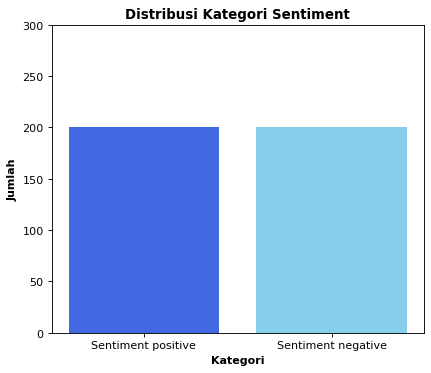

In [11]:
height = df['Sentiment'].value_counts()
labels = ('Sentiment positive', 'Sentiment negative')
y_pos = np.arange(len(labels))

plt.figure(figsize=(6, 5), dpi=(80))
plt.ylim(0, 300)
plt.title('Distribusi Kategori Sentiment', fontweight='bold')
plt.xlabel('Kategori', fontweight='bold')
plt.ylabel('Jumlah', fontweight='bold')
plt.bar(y_pos, height, color=['royalblue', 'skyblue'])
plt.xticks(y_pos, labels)
plt.show()


# Text Preprocessing

## Case Folding

In [12]:
def casefolding(text):
    text = text.lower()
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)  
    text = re.sub(r'#\w+', '', text)  
    text = re.sub(r'https?://\S+', '', text)  
    text = re.sub(r'<[^>]+>', '', text)  
    text = re.sub(r'[^A-Za-z\s.+:()?<>]', '', text)  
    return text

In [13]:
raw_sample = df['ArtScape Comment Text'].iloc[17]
case_folding = casefolding(raw_sample)

print('Raw df\t:', raw_sample)
print('Case folding\t:', case_folding)

Raw df	:  <USERNAME> ahhh katanya jaga ucapan, lahh ucapan dia ngk dijaga sendiri.. dasar munafik.. dasar betina zaman now ellu kali yangg kelebihan micin.. loe sendiri otak loe kan di selangkangan mana paham.. semoga Tuhan ampunin kemunafikan loe cun
Case folding	:   ahhh katanya jaga ucapan lahh ucapan dia ngk dijaga sendiri.. dasar munafik.. dasar betina zaman now ellu kali yangg kelebihan micin.. loe sendiri otak loe kan di selangkangan mana paham.. semoga tuhan ampunin kemunafikan loe cun


### Normalization

In [14]:
file_path = "C:/Users/user/Documents/Capstone Analisis Sentimen/Dataset/key_norm.csv"
key_norm = pd.read_csv(file_path)

print(key_norm.head())
key_norm.shape

   _id      singkat       hasil
0    1         abis       habis
1    2       accent     tekanan
2    3       accept      terima
3    4     accident  kecelakaan
4    5  achievement    prestasi


(3721, 3)

In [15]:
def text_normalize(text):
    text = ' '.join([key_norm[key_norm['singkat'] == word]['hasil'].values[0] if (key_norm['singkat'] == word).any() else word for word in text.split()]) 
    text = str.lower(text)
    return text

## Filtering

In [16]:
from nltk.corpus import stopwords

stopwords_ind = stopwords.words('indonesian')
more_stopword = ['tsel', 'gb', 'rb']
stopwords_ind = stopwords_ind + more_stopword
len(stopwords_ind)


761

In [17]:
stopwords_ind[:20]

['ada',
 'adalah',
 'adanya',
 'adapun',
 'agak',
 'agaknya',
 'agar',
 'akan',
 'akankah',
 'akhir',
 'akhiri',
 'akhirnya',
 'aku',
 'akulah',
 'amat',
 'amatlah',
 'anda',
 'andalah',
 'antar',
 'antara']

In [18]:
def remove_stop_words(text):
    clean_words = []
    text = text.split()
    for word in text:
        if word not in stopwords_ind and word not in more_stopword:
            clean_words.append(word)
    return " ".join(clean_words)


In [19]:
raw_sample = df['ArtScape Comment Text'].iloc[17]
case_folding = casefolding(raw_sample)
normalized_text = text_normalize(case_folding)  
stopword_removal = remove_stop_words(normalized_text) 

print('Raw df\t\t:', raw_sample)
print('Case folding\t:', case_folding)
print('Stopword Removal\t:', stopword_removal)

Raw df		:  <USERNAME> ahhh katanya jaga ucapan, lahh ucapan dia ngk dijaga sendiri.. dasar munafik.. dasar betina zaman now ellu kali yangg kelebihan micin.. loe sendiri otak loe kan di selangkangan mana paham.. semoga Tuhan ampunin kemunafikan loe cun
Case folding	:   ahhh katanya jaga ucapan lahh ucapan dia ngk dijaga sendiri.. dasar munafik.. dasar betina zaman now ellu kali yangg kelebihan micin.. loe sendiri otak loe kan di selangkangan mana paham.. semoga tuhan ampunin kemunafikan loe cun
Stopword Removal	: ahhh jaga ucapan lahh ucapan dijaga sendiri.. dasar munafik.. dasar betina zaman ellu kali yangg kelebihan micin.. otak selangkangan paham.. semoga tuhan ampunin kemunafikan cun


## Stemming

In [20]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemming(text):
    text = stemmer.stem(text)
    return text

In [21]:
raw_sample = df['ArtScape Comment Text'].iloc[17]
case_folding = casefolding(raw_sample)
normalized_text = text_normalize(case_folding)  
stopword_removal = remove_stop_words(normalized_text) 
text_stemming = stemming(stopword_removal)

print('Raw df\t\t:', raw_sample)
print('Case folding\t:', case_folding)
print('Stopword Removal\t:', stopword_removal)
print('Stemming\t\t:', text_stemming)

Raw df		:  <USERNAME> ahhh katanya jaga ucapan, lahh ucapan dia ngk dijaga sendiri.. dasar munafik.. dasar betina zaman now ellu kali yangg kelebihan micin.. loe sendiri otak loe kan di selangkangan mana paham.. semoga Tuhan ampunin kemunafikan loe cun
Case folding	:   ahhh katanya jaga ucapan lahh ucapan dia ngk dijaga sendiri.. dasar munafik.. dasar betina zaman now ellu kali yangg kelebihan micin.. loe sendiri otak loe kan di selangkangan mana paham.. semoga tuhan ampunin kemunafikan loe cun
Stopword Removal	: ahhh jaga ucapan lahh ucapan dijaga sendiri.. dasar munafik.. dasar betina zaman ellu kali yangg kelebihan micin.. otak selangkangan paham.. semoga tuhan ampunin kemunafikan cun
Stemming		: ahhh jaga ucap lahh ucap jaga sendiri dasar munafik dasar betina zaman ellu kali yangg lebih micin otak selangkang paham moga tuhan ampunin munafik cun


# Text Preprocessing Pipeline

In [22]:
def text_preprocessing_process(text):
    text = casefolding(text)
    text = text_normalize(text)
    text = remove_stop_words(text)
    text = stemming(text)
    return text

In [23]:
%%time
df['clean_teks'] = df['ArtScape Comment Text'].apply(text_preprocessing_process)

CPU times: total: 2min 13s
Wall time: 3min 34s


In [24]:
df

,Id,Sentiment,ArtScape Comment Text,clean_teks
0,1,0,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...,tolol hubung nya gugur pakai hijab syar bilang...
1,2,0,Geblek lo tata...cowo bgt dibela2in balikan......,bodoh tata cowo banget bain balik hadeww ntar ...
2,3,0,Kmrn termewek2 skr lengket lg duhhh kok labil ...,kemarin mewek skr lengket duhhh labil banget s...
3,4,0,"Intinya kalau kesel dengan ATT nya, gausah ke ...",inti kesel att nya anak juga kasihan kembang p...
4,5,0,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha...",hadewwwww permpuan lgsakit jiwaknp peran utama...
...,...,...,...,...
395,396,1,Bangga sama suami yg selalu ingat istri disela...,bangga suami istri sela apa profesi kau juara ...
396,397,1,Apaoun pekerjaannya yg penting halal u tuk men...,apaoun kerja halal tuk nafkah keluarga semangat
397,398,1,Gojek itu mayoritas pegangguran yang lama gak ...,gojek mayoritas pegangguran kerja putus asaa t...
398,399,1,<USERNAME> aslinya cantik dan ayu loh mbak kr...,asli cantik ayu loh mbak temu langsung sembak ...


In [25]:
df.to_csv('clean_data.csv')

# Feature Engineering

In [26]:
x = df['clean_teks']
y = df['Sentiment']

In [27]:
x

0      tolol hubung nya gugur pakai hijab syar bilang...
1      bodoh tata cowo banget bain balik hadeww ntar ...
2      kemarin mewek skr lengket duhhh labil banget s...
3      inti kesel att nya anak juga kasihan kembang p...
4      hadewwwww permpuan lgsakit jiwaknp peran utama...
                             ...                        
395    bangga suami istri sela apa profesi kau juara ...
396      apaoun kerja halal tuk nafkah keluarga semangat
397    gojek mayoritas pegangguran kerja putus asaa t...
398    asli cantik ayu loh mbak temu langsung sembak ...
399    suami umur mbak tua alhamdulillah suami kekana...
Name: clean_teks, Length: 400, dtype: object

In [28]:
y

0      0
1      0
2      0
3      0
4      0
      ..
395    1
396    1
397    1
398    1
399    1
Name: Sentiment, Length: 400, dtype: int32

## Feature Extraction

*mengubah teks menjadi vektor*

In [29]:
bow = CountVectorizer(ngram_range=(1, 1))
bow.fit(x)

CountVectorizer()

In [30]:
print(len(bow.get_feature_names_out()))

2343


In [31]:
print(bow.get_feature_names_out())

['aamiin' 'aammiinnn' 'abal' ... 'zholimi' 'zina' 'zzzzz']


In [32]:
x_bow = bow.transform(x).toarray()
x_bow

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

*data di atas ini siap untuk dimasukan dalam proses building model*

In [33]:
df_bow = pd.DataFrame(x_bow, columns=bow.get_feature_names_out())
df_bow

,aamiin,aammiinnn,abal,abang,abbey,abege,abiiis,abis,abiss,abu,...,yh,yoo,youtube,yra,yuk,yutub,zaman,zholimi,zina,zzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
396,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
397,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
398,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
with open('bow_feature.pickle', 'wb') as output:
    pickle.dump(x_bow, output)

## Feature Extraction (TF-IDF and N-Gram)

*mengubah teks menjadi vector menggunakan metode TF-IDF*

In [35]:
tf_idf = TfidfVectorizer(ngram_range=(1, 1))
tf_idf.fit(x)

TfidfVectorizer()

In [36]:
print(len(tf_idf.get_feature_names_out()))
print(tf_idf.get_feature_names_out())

2343
['aamiin' 'aammiinnn' 'abal' ... 'zholimi' 'zina' 'zzzzz']


In [37]:
x_tf_idf = tf_idf.transform(x).toarray()
x_tf_idf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [38]:
df_tf_idf = pd.DataFrame(x_tf_idf, columns=tf_idf.get_feature_names_out())
df_tf_idf

,aamiin,aammiinnn,abal,abang,abbey,abege,abiiis,abis,abiss,abu,...,yh,yoo,youtube,yra,yuk,yutub,zaman,zholimi,zina,zzzzz
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.237467,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
396,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
397,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
398,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
with open('tf_idf_feature.pickle', 'wb') as output:
    pickle.dump(x_tf_idf, output)

## Feature Selection (Chi Square)

In [40]:
x = np.array(df_tf_idf)
y = np.array(y)

*code di atas ini adalah proses mengubah nilai data tabular tf-idf menjadi array agar dapat dijalankan pada proses seleksi fitur*

In [41]:
chi2_features = SelectKBest(chi2, k=1000)
x_kbest_features = chi2_features.fit_transform(x, y)

print('original feature number:', x.shape[1])
print('reduced feature number:', x_kbest_features.shape[1])

original feature number: 2343
reduced feature number: 1000


In [42]:
df_chi2 = pd.DataFrame(chi2_features.scores_, columns=['nilai'])
df_chi2

,nilai
0,1.002563
1,0.267255
2,0.929984
3,0.000207
4,0.488810
...,...
2338,0.211402
2339,0.179832
2340,0.226805
2341,0.331457


In [43]:
feature = tf_idf.get_feature_names_out()
df_chi2['fitur'] = feature
df_chi2

,nilai,fitur
0,1.002563,aamiin
1,0.267255,aammiinnn
2,0.929984,abal
3,0.000207,abang
4,0.488810,abbey
...,...,...
2338,0.211402,yutub
2339,0.179832,zaman
2340,0.226805,zholimi
2341,0.331457,zina


In [56]:
with open('kbest_feature.pickle', 'rb') as f:
    x_kbest_features = pickle.load(f)

# Training Model Naive Bayes

In [57]:
x_train, x_test, y_train, y_test = train_test_split(x_kbest_features, y, test_size=0.2, random_state=42)

*Training model*

In [58]:
algorithm = MultinomialNB()
model = algorithm.fit(x_train, y_train)

dump(model, filename='model_1.joblib')

['model_1.joblib']

*prediksi label pada data uji*

In [59]:
model_pred = model.predict(x_test)
model_pred

array([1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1])

*tampilkan label asli pada data uji*

In [60]:
y_test 

array([1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1])

# Model Evaluation

### Evaluation SVM

*hitung jumlah data yang berhasil di prediksi model dan jumlah data yang salah di prediksi*

In [61]:
prediksi_benar = (model_pred == y_test).sum()
prediksi_salah = (model_pred != y_test).sum()

print('jumlah prediksi benar\t:', prediksi_benar)
print('jumlah prediksi salah\t:', prediksi_salah)

accuracy = prediksi_benar / (prediksi_benar + prediksi_salah)*100
print('akurasi pengujian\t:', accuracy, '%')

jumlah prediksi benar	: 76
jumlah prediksi salah	: 4
akurasi pengujian	: 95.0 %


In [62]:
cm = confusion_matrix(y_test, model_pred)
print('confusion_matrix:\n', cm)

confusion_matrix:
 [[40  4]
 [ 0 36]]


In [63]:
print('classification_report:\n', classification_report(y_test, model_pred))

classification_report:
               precision    recall  f1-score   support

           0       1.00      0.91      0.95        44
           1       0.90      1.00      0.95        36

    accuracy                           0.95        80
   macro avg       0.95      0.95      0.95        80
weighted avg       0.96      0.95      0.95        80



*cross validation*

In [64]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=50)

cv_accuracy = (cross_val_score(model, x_kbest_features, y, cv=cv, scoring='accuracy'))
avg_accuracy = np.mean(cv_accuracy)

print('akurasi setiap split:', cv_accuracy, '\n')
print('rata-rata akurasi pada cross validation:', avg_accuracy)

akurasi setiap split: [0.9    0.95   0.9625 0.95   0.9375 0.95   0.925  0.9    0.9375 0.975 ] 

rata-rata akurasi pada cross validation: 0.9387500000000001


# Simple Deployment

In [72]:
model = load('model_1.joblib')
vocab = x_kbest_features.tolist()

# Masukan Teks anda:

In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer

input_text = "mau cari sensasi doang tuh"
pre_input_text = text_preprocessing_process(input_text)
tf_idf_vec = TfidfVectorizer(vocabulary=set(vocab))
result = model.predict(tf_idf_vec.fit_transform([pre_input_text])) 

print('hasil Text Preprocessing :', pre_input_text)

if (result==0):
    komentar = 'komentar negative'
elif (result==1):
    komentar = 'komentar positive'
    
print('hasil prediksi', input_text, 'adalah\n', komentar)


TypeError: unhashable type: 'list'